---
title: "[stock prediction] 1.1 머신러닝을 위한 주가 데이터셋 생성"
author: "agsu"
date: "7/06/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock1.png
---

# 1. baseline model  
## 1.1. 머신러닝을 위한 주가 데이터셋 생성
본 글에서는 `시가, 저가, 고가, 종가, 거래량, 변화율`로 구성되어있는 주가 데이터셋을 머신러닝 학습을 위한 형태로 전처리한다. 또한, 이 전처리 과정에서 처음에 시도하였던 방법으로부터 점차 효율적으로 개선하여 처리 시간을 줄이는 방법의 과정을 담았다.

<br>

### 데이터셋 정의
본 연구에서 머신러닝 학습을 위한 데이터셋은 다음과 같이 정의하였다. 

- **`조건`**: 전체 약 2000개 종목 중 2018년 부터 존속하였던 기업 중 거래대금이 1000억 이상 발생한 날짜 (거래대금은 추후에 수정 예정) 

- **`독립변수 정의`**: __`조건`__ 에서 선별한 특정 날짜를 D0라고 했을 때, D-9, D-8, ..., D0, 총 10일 치의 `Open`, `High`, `Low`, `Close`, `거래대금(trading_value)` 

- **`종속변수 정의`**:  조건에 부합하는 특정 날짜(D0) 대비 다음날(D+1) 날짜의 종가(close)가 2%이상 상승하면 `1`, 상승하지 않으면 `0` 

- **`학습&시험 데이터셋 정의`**
  
    - **`train dataset`**: 2018년 1월 2일 - 2020년 12월 31일 (2년)
  
    - **`test dataset`**: 2021년 1월 2일 ~ 2021년 6월 31일 (6개월)

<br>

### 데이터셋 생성 과제
데이터셋 생성을 3단계의 과정으로 나누어 진행했다.

- **`과제 I`**: 종목 리스트 생성-2018년 부터 존속하였던 기업(상장일 2018년 1월 1일 이전 기업)  선별

- **`과제 II`**: __`과제I`__ 의 기업 중 거래대금이 1000억 이상 발생했던 특정 날짜 선별 (`거래대금`=`거래량`X`종가` 로 계산)

- **`과제 III`**: __`과제II`__ 의 날짜에 대해 최종 머신러닝 데이터 생성하여 csv 파일로 저장 

<br>


주가 데이터셋 생성 절차는 `df2list` - `dictionary` - `MultiProcessing` - `MySQL` 순서로 진행한다. 4가지 절차를 통해 데이터셋이 달라지는 것은 아니고, 속도를 개선시키는 방향으로의 효율적인 코드를 짜기 위한 훈련 과정이다. 대규모 데이터셋을 다루기 위해서는 효율적인 코딩을 통해 속도를 개선하는 것도 중요한 일이다. 특히 이번에 사용하는 주가 데이터셋은 양이 많을 뿐만 아니라, `fdr` 라이브러리를 사용하여 외부에서 불러와야하기 때문에 데이터셋을 구성하는 것만 해도 속도가 상당히 느리다. 이러한 문제점을 해결하고자 본 포스팅에서는 4단계에 걸친 데이터셋 생성 과정을 보여준다.  

<br>



### 목차
- __(0)__ Finance Data Reader를 이용한 주가 데이터셋 - `DataFrame`
- __(1)__ Finance Data Reader를 이용한 주가 데이터셋 - `df2list`
- __(2)__ Finance Data Reader를 이용한 주가 데이터셋 - `dictionary`
- __(3)__ Finance Data Reader를 이용한 주가 데이터셋 - `MultiProcessing`
- __(4)__ Finance Data Reader를 이용한 주가 데이터셋 - `MySQL`
- __(5)__ 최종 머신러닝 데이터셋 

### 필요 라이브러리 __import__

In [ ]:
# finance datareader 설치 
# ! pip install -U finance-datareader

In [4]:
import pandas as pd
import os
from tqdm import tqdm
import FinanceDataReader as fdr
import time

# 경고 메시지 무시 
import warnings
warnings.filterwarnings(action='ignore')

<br>
<br>


## __(0)__ Finance Data Reader를 이용한 주가 데이터셋 - `DataFrame`
속도 비교를 위해 기존 데이터의 타입인 `DataFrame`을 사용하여 데이터셋을 생성한다.

__과제 I__

In [5]:
df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]

# 회사명, 종목코드, 상장일 컬럼만 사용 
df_code = df[['회사명', '종목코드', '상장일']]

# 종목코드를 6자리로 맞춰 준다. 
df_code['종목코드'] = df_code['종목코드'].apply(lambda x : str(x).zfill(6))
display(df_code.head(3))
print()

# 상장일이 2018년 1월 1일 이전인 종목코드 선별 
start_time = time.time()
lst_code = df_code.loc[df_code['상장일'] < '2018-01-01', '종목코드'].to_list()
print("걸린 시간: ", time.time() - start_time)
print()
print('상장일 2018-01-01 이전 종목코드: ', lst_code[:5])
print()
print(f'총 {len(df_code)} 개의 종목 중 {len(lst_code)} 개의 종목 선별')

,회사명,종목코드,상장일
0,DL,000210,1976-02-02
1,DRB동일,004840,1976-05-21
2,DSR,155660,2013-05-15



걸린 시간:  0.0006058216094970703

상장일 2018-01-01 이전 종목코드:  ['000210', '004840', '155660', '078930', '001390']

총 2536 개의 종목 중 1972 개의 종목 선별


__과제 II__

In [62]:
stock_dict = {}
for code in tqdm(lst_code): 
    stock = fdr.DataReader(code, start='20180101', end='20201231')
    stock['trading'] = stock['Volume'] * stock['Close'] # 거래대금 컬럼 추가
    
    if sum(stock['trading'] >= 100000000000) >= 1: # 거래대금이 1000억 이상인 데이터가 하나 이상 존재하면
        stock_dict[code] = stock[stock['trading'] >= 100000000000].index # index == Date 

print(f'총 {len(lst_code)} 개의 종목 중 {len(stock_dict)} 개의 종목 사용')

100%|██████████████████████████████████████████████| 1977/1977 [02:58<00:00, 11.08it/s]

총 1977 개의 종목 중 799 개의 종목 사용


먼저, fdrDataReader 패키지를 사용하여 거래대금이 1000억 이상인 데이터의 날짜를 stock_dict에 stock_dict[code] = [날짜,...] 의 형식으로 넣어주었다.

In [63]:
# 선별된 종목과 날짜를 lst_code_date에 넣어준다. 
lst_code_date = []
for code in tqdm(stock_dict): 
    for date in (stock_dict[code]):
        lst_code_date.append([code, date])
        
print(f'선별된 날짜는 총 {len(lst_code_date)}개')

100%|█████████████████████████████████████████████| 799/799 [00:00<00:00, 13125.89it/s]

선별된 날짜는 총 14182개


lst_code_date에 [코드, 날짜] 형식으로 추가한다.

__과제 III__

In [64]:
data_dict = {'code': [], 'd0': [], 'info': [], 'up': []}
for code, date in tqdm(lst_code_date):
    start_date = '20171201' # 2018년 초반 날짜가 D0라면 2017년 데이터 필요 (D-9~D-1)
    end_date = '20210130' # 2020년 후반 날짜가 D0라면 2021년 데이터 필요 (D+1) 
    stock = fdr.DataReader(code, start = start_date, end = end_date)
    stock.reset_index(inplace=True) # 'Date' index -> column 
    
    D9_index = stock[stock['Date'] == str(date)].index[0] - 9 # D-9 날짜의 인덱스  
    next_index = stock[stock['Date'] == str(date)].index[0] + 1 # D+1 날짜의 인덱스  
        
    # 종목코드 (code)
    data_dict['code'].append(code) 
    
    # 기준일 (d0)
    data_dict['d0'].append(date)
    
    # D-9 ~ D+1, 총 11일치의 sub stock DataFrame 생성 
    sub_stock = stock.iloc[D9_index:next_index+1]
    sub_stock['trading'] = sub_stock['Close'] * sub_stock['Volume'] # 거래대금 컬럼 추가 
   
    
    # 10일 간의 데이터 (info)
    info_list = []
    for i in range(10):        
        info_list.append(sub_stock.iloc[i, [1, 2, 3, 4, -1]].to_list())
    remove_list=['[', ']']
    for i in range(2): 
        info_list = f'{info_list}'.replace(remove_list[i], '')
    data_dict['info'].append(info_list)    
        
        
    # D+1 종가 2% 상승 여부 (up)
    up = sub_stock.iloc[-2]['Close'] + 0.02 * sub_stock.iloc[-2]['Close']
    
    if sub_stock.iloc[-1]['Close'] >= up: 
        data_dict['up'].append(1)
    else: 
        data_dict['up'].append(0)

100%|████████████████████████████████████████████| 14182/14182 [17:08<00:00, 13.78it/s]


In [65]:
df_result = pd.DataFrame(data_dict)
display(df_result.head()) 

# 최종 결과 데이터셋 txt 파일 저장 
df_result.to_csv("assignment3.txt")
print(f'생성된 데이터의 개수는 {len(pd.read_csv("assignment3.txt"))} 개')

,code,d0,info,up
0,000210,2018-01-26,"78343, 78614, 76987, 77892, 9590608284, 77801,...",0
1,000210,2018-08-08,"68855, 69397, 67590, 69036, 6067435968, 69487,...",0
2,000210,2020-04-02,"44819, 52951, 44322, 51145, 15615437965, 47439...",0
3,000210,2020-09-11,"80783, 84487, 78524, 78524, 61554885076, 79608...",0
4,000210,2020-12-11,"76174, 76174, 72289, 72289, 76043112348, 72831...",0


생성된 데이터의 개수는 14182 개


<br>

최종적으로 머신러닝 학습을 위한 데이터셋을 처리하는 코드는 총 17분이 걸렸다. 연구 초반에 가장 첫 번째로 작성한 코드인데, 지금 보니 확실히 비효율적으로 작성했던 부분이 많은 것 같다. 

<br>


__개선해야할 사항__

- __`속도 개선`__: __`과제III`__ 은 약 17분이 걸린 것을 보아 속도 면에서 상당히 비효율적이었다. (거래대금을 10억으로 설정했을 때 1% 진행에 5분이 걸렸습니다. 그럼 총 500분이 걸릴 것으로 예상할 수 있다.)


- __`# 10일 간의 데이터`__ 부분: `info_list`에 데이터를 추가하는 과정에서 억지로 포맷을 맞추기 위해 불필요한 `for문`이 들어갔다. 


- __`# D+1 종가 2% 상승 여부`__ 부분: 전 날 대비 2% 상승율을 직접 계산해 주었는데, 이미 변화율이 계산 되어 있는 `change`라는 컬럼을 사용하는 것으로 대체한다. 


- __`txt 파일 저장`__: `DataFrame`으로 생성을 한 후에 `txt` 파일로 저장했는데, 데이터 생성 시 파일 입출력 `write()`를 사용해서 바로 `txt` 파일로  저장하는 방식으로 변경한다. 

-------

<br>
<br>

## (1) Finance Data Reader를 이용한 주가 데이터셋 - `df2list` 
첫번째 방법은 `DataFrame` 사용을 지양하고, `python`의 기본 데이터 타입인 `list`로 바꾸어 사용하는 방법입니다. 이로써 `column` 중심의 연산을 `row` 중심의 연산으로 바꾼다. 이 방법에서는 속도 개선 보다는 `(0)`번 방법의 코드에서 효율적이지 못했던 부분을 고치고 깔끔한 코드로 보완한다. 

__과제 I__

In [7]:
# (0) 방법에서 사용했던 df_code 데이터 프레임 사용 
display(df_code.head(2))

# 🌟 dataframe -> list 
lst_stock = df_code.values.tolist()
print(lst_stock[:2])
print()


lst_code = [] # 선별 된 코드를 담을 리스트 
start_time = time.time()
for row in lst_stock:
    code, date = row[1], row[2]
    if date <= '2018-01-01':
        lst_code.append(code)
print("걸린 시간: ", time.time() - start_time)
print()

        
print('상장일 2018-01-01 이전 종목코드: ', lst_code[:4])
print()
print(f'총 {len(df_code)} 개의 종목 중 {len(lst_code)} 개의 종목 선별')

,회사명,종목코드,상장일
0,DL,000210,1976-02-02
1,DRB동일,004840,1976-05-21


[['DL', '000210', '1976-02-02'], ['DRB동일', '004840', '1976-05-21']]

걸린 시간:  0.0004563331604003906

상장일 2018-01-01 이전 종목코드:  ['000210', '004840', '155660', '078930']

총 2536 개의 종목 중 1972 개의 종목 선별


__과제 II__

In [4]:
lst_code_date = []
for code in tqdm(lst_code):
    stock = fdr.DataReader(code, start='20180102', end='20201231')
    stock.reset_index(inplace=True)
    
    # 🌟 dataframe -> list 
    lst_stock = stock.values.tolist()
    
    for row in lst_stock: 
        date, trading_value = row[0], row[4]*row[5]
        if trading_value >= 100000000000:  # 거래대금 1000억 이상
            lst_code_date.append([code, date.date().strftime("%Y%m%d")])
            
print(f'선별된 날짜는 총 {len(lst_code_date)}개')

100%|██████████████████████████████████████████████| 1977/1977 [02:55<00:00, 11.26it/s]

선별된 날짜는 총 14182개


__과제 III__

In [12]:
OF = open('assignment3.txt','w')

for code, date in tqdm(lst_code_date):
    start_date = '20180101' 
    end_date = '20201231' 
    stock = fdr.DataReader(code, start = start_date, end = end_date)
    stock.reset_index(inplace=True) # 'Date' index -> column 
    
    
    # 🌟 dataframe -> list 
    lst_stock = stock.values.tolist()
    
    
    for idx, row in enumerate(lst_stock): 
        if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
            continue 
        
        if row[0].date().strftime("%Y%m%d") == date: 
            
            # D-9 ~ D0 데이터만 담기
            sub_stock = lst_stock[idx-9:idx+1]
            
            # 10일 간의 데이터 
            lst_info = []
            for row2 in sub_stock:
                lst_prices, trading_value = row2[1:5], row[4]*row[5]
                lst_info += lst_prices + [trading_value]
                
            info = ','.join(map(str, lst_info))
            
            # D+1 종가 2% 상승 여부 (up)
            change = lst_stock[idx+1][6]
            label = int(change >= 0.02)
            
            # 저장 
            OF.write(f'{code}\t{date}\t{lst_info}\t{label}\n')
            
OF.close()

print(f'생성된 데이터의 개수는 {len(pd.read_csv("assignment3.txt"))} 개')

100%|████████████████████████████████████████████| 14182/14182 [17:43<00:00, 13.33it/s]

생성된 데이터의 개수는 13939 개


- `OF.write()`를 사용함으로써 블필요한 `DataFrame` 을 생성하지 않는다.


- __\# 10일간의 데이터__ 부분은 `join()` 함수를 사용하여 불필요한 for문 사용을 줄였고, __\# D+1 종가 2% 상승 여부 (up)__ 부분은 전날 대비 종가 변화율을 계산하지 않고 `change` 컬럼을 활용하는 것으로 바꾸었다. 



- __`속도에 대한 문제점`__ : 전 보다 깔끔한 코드로 보완이 되었지만, 아직 속도에 대한 문제점이 남아있다. 속도를 개선하기 위해서는 `fdr` 라이브러리를 최소한으로 사용해야한다. 하지만 지금 [코드, 날짜]의 형태로 for문이 돌고있기 때문에, 중복되는 같은 Code를 여러 번 불러오고 있다. 이를 해결하기 위해 lst_code_date 리스트 대신, `dictionary`를 사용하는 방법으로 넘어간다. 

------------

<br>
<br>

## (2) Finance Data Reader를 이용한 주가 데이터셋 - `dictionary` 


`dictionary`를 사용하는 방법은 __`과제III`__ 의 속도를 개선할 수 있다. `fdr` 라이브러리를 최소한으로 사용하고, `for`문을 최대한 줄인다. 현재 문제점은 날짜를 기준으로 `for`문이 돌아가기 때문에 같은 데이터(같은 종목)가 여러번 불러와지는 경우가 다수 존재한다는 것이다. 따라서 __`과제II`__ 에서 `code`별 `D0` 날짜 리스트를 `dictionary` 타입으로 생성하고, __`과제III`__ 에서 `code` 당 한번만 `fdr` 라이브러리를 사용하도록 바꾸어준다. 

__과제 I__

__`과제I`__ 은 앞의 방법과 같으므로 생략한다. 

In [14]:
print('상장일 2018-01-01 이전 종목코드: ', lst_code[:4])
print()
print(f'총 {len(df_code)} 개의 종목 중 {len(lst_code)} 개의 종목 선별')

상장일 2018-01-01 이전 종목코드:  ['000210', '004840', '155660', '078930']

총 2507 개의 종목 중 1977 개의 종목 선별


__과제 II__

In [15]:
dict_code2date = {}
for code in tqdm(lst_code): 
    start_date = '20180102'
    end_date = '20201231'
    stock = fdr.DataReader(code, start = start_date, end = end_date)
    stock.reset_index(inplace=True)    
    
    # 🌟 dataframe -> list     
    lst_stock = stock.values.tolist()
    
    for row in lst_stock: 
        date, trading_value = row[0], row[4]*row[5]
        if trading_value >= 100000000000:
            if code not in dict_code2date.keys():
                dict_code2date[code] = [date.date().strftime("%Y%m%d")]
            else:
                dict_code2date[code].append(date.date().strftime("%Y%m%d"))

print(f'총 {len(lst_code)} 개의 종목 중 {len(dict_code2date)} 개의 종목 사용')

100%|██████████████████████████████████████████████| 1977/1977 [02:42<00:00, 12.14it/s]

총 1977 개의 종목 중 799 개의 종목 사용


__과제 III__

In [19]:
OF = open('assignment3.txt', 'w')
for code in tqdm(dict_code2date): 
    # code의 stock 
    start_date = '20180101' 
    end_date = '20201231' 
    stock = fdr.DataReader(code, start = start_date, end = end_date)
    stock.reset_index(inplace=True)
    
    # 🌟 dataframe -> list     
    lst_stock = stock.values.tolist()  
       
    for idx, row in enumerate(lst_stock):   
        if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
            continue 
        
        date = row[0].date().strftime("%Y%m%d") 
        if date not in dict_code2date[code]: # 조건에 부합하는 날짜 (D0 날짜)를 발견할 때까지 continue
            continue 

        # D-9 ~ D0 데이터만 담기
        sub_stock = lst_stock[idx-9:idx+1] 
        
        # 10일간의 데이터 
        lst_info = []
        for row2 in sub_stock:
            lst_prices, trading_value = row2[1:5], row2[4]*row2[5]
            lst_info += lst_prices + [trading_value]
        info = ','.join(map(str, lst_info))

        # D+1 종가 2% 상승 여부 
        label = int(lst_stock[idx+1][6] >= 0.02)

        # 저장 
        OF.write(f'{code}\t{date}\t{info}\t{label}\n')
                         
OF.close()   

print(f'생성된 데이터의 개수는 {len(pd.read_csv("assignment3.txt"))} 개')

100%|████████████████████████████████████████████████| 799/799 [01:07<00:00, 11.84it/s]

생성된 데이터의 개수는 13939 개


날짜 중심의 for문을 코드 중심으로 변경함으로써 fdr 라이브러리 불러오는 것을 최소화하여, 약 17분이 걸리던 시간이 1분으로 대폭 줄어든 것을 확인하였다.

---------

<br>
<br>

## (3) Finance Data Reader를 이용한 주가 데이터셋 - `MultiProcessing` 


- `multi processing(다중 처리)`: 컴퓨터 시스템 한 대에 두개 이상의 중앙 처리 장치 (CPU) 를 이용하여 병렬처리하는 것 


- `python multi processing` 문서: [https://docs.python.org/ko/3/library/multiprocessing.html](https://docs.python.org/ko/3/library/multiprocessing.html).


`python`은 `multiprocessing` 라이브러리를 통해 다중 처리를 지원한다. 여러 개의 `코어`를 연산에 사용함으로써 많은 작업을 빠른 시간에 처리해줄 수 있다는 장점이 있다. 



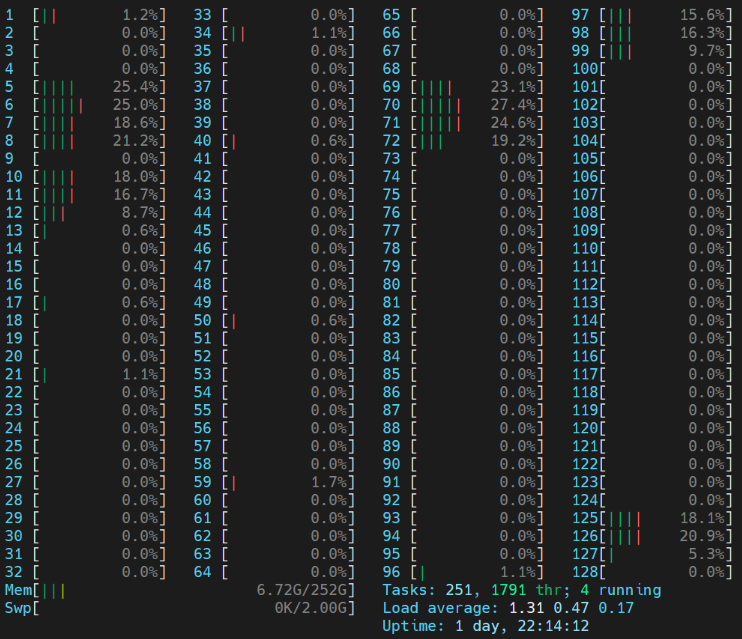
[ `core=10`으로 설정하여 multi processing을 수행할 때 코어 사용 ]

In [20]:
# MultiProcessing을 위한 library import 
import time, os
from multiprocessing import Pool

__과제 I__

__`과제I`__ 은 앞의 방법과 같으므로 생략한다. 

In [21]:
print('상장일 2018-01-01 이전 종목코드: ', lst_code[:4])
print()
print(f'총 {len(df_code)} 개의 종목 중 {len(lst_code)} 개의 종목 선별')

상장일 2018-01-01 이전 종목코드:  ['000210', '004840', '155660', '078930']

총 2507 개의 종목 중 1977 개의 종목 선별


__과제 II__

- `multi processing`을 위한 함수 정의 

In [22]:
def make_lst_result(code): 
    start_date = '20180101'
    end_date = '20201231'
    
    lst_date = []
    
    stock = fdr.DataReader(code, start = start_date, end = end_date)
    stock.reset_index(inplace=True)
  
    # 🌟 dataframe -> list
    lst_stock = stock.values.tolist()
    
    for row in lst_stock: 
        if row[4] * row[5] >= 100000000000: 
            lst_date.append(row[0].date().strftime("%Y%m%d"))
        
    return [code, lst_date]

- `multi processing` 수행

In [23]:
start_time = time.time()
num_cores = 10
pool = Pool(num_cores)
lst_code_date = pool.map(make_lst_result, lst_code)
pool.close()
pool.join()
print(time.time() - start_time) 

17.97966194152832


앞서 약 2분 40초 가 걸렸던 __`과제II`__ 를 `multi processing`을 사용하여 17초대로 단축시켰다.

- `dictionary` 생성 

In [24]:
dict_code2date = {}

for code, lst_date  in tqdm(lst_code_date):
    if lst_date == []:
        continue
    dict_code2date[code] = lst_date
            
print(f'총 {len(lst_code)} 개의 종목 중 {len(dict_code2date)} 개의 종목 사용')

100%|█████████████████████████████████████████| 1977/1977 [00:00<00:00, 1610124.08it/s]

총 1977 개의 종목 중 799 개의 종목 사용


__과제 III__

- `multi processing`을 위한 함수 정의 

In [25]:
def make_lst_result2(code): 
    # code의 stock 
    start_date = '20180101' 
    end_date = '20201231' 
    stock = fdr.DataReader(code, start = start_date, end = end_date)
    stock.reset_index(inplace=True)
    
    # 🌟 dataframe -> list     
    lst_stock = stock.values.tolist()  
       
    lst_result = []
        
    for idx, row in enumerate(lst_stock): 
        
        if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
            continue 
            
        date = row[0].date().strftime("%Y%m%d") 
        if date not in dict_code2date[code]: # 조건에 부합하는 날짜 (D0 날짜)를 발견할 때까지 continue
            continue 

        # D-9 ~ D0 데이터만 담기
        sub_stock = lst_stock[idx-9:idx+1] 
        
        # 10일간의 데이터 
        lst_info = []
        for row2 in sub_stock:
            lst_prices, trading_value = row2[1:5], row2[4]*row2[5]
            lst_info += lst_prices + [trading_value]
        info = ','.join(map(str, lst_info))

        # D+1 종가 2% 상승 여부 
        label = int(lst_stock[idx+1][6] >= 0.02)
        
        lst_result.append([code, date, info, label])
        
    return lst_result

- `multi processing` 수행

In [26]:
start_time = time.time()
num_cores = 10
pool = Pool(num_cores)
lst_data = pool.map(make_lst_result2, dict_code2date.keys())
pool.close()
pool.join()
print(time.time() - start_time) 

8.186521768569946


앞서 진행했던 방법에서 1분이 걸렸던 작업이 `multi processing`을 사용하여 8초로 줄어들었다. 

- `txt` 파일 생성 

In [28]:
OF = open("assignment3_multi_processing.txt", 'w')

for row in lst_data: 
    for num in range(len(row)): 
        OF.write('\t'.join(map(str, row[num])) + '\n')
        
OF.close()

print(f'생성된 데이터의 개수는 {len(pd.read_csv("assignment3_multi_processing.txt"))} 개')

생성된 데이터의 개수는 13939 개


-----------

<br>
<br>

### __(4)__ Finance Data Reader를 이용한 주가 데이터셋 - `MySQL`

4번째 방법은 `MySQL`을 사용하는 것이다. 외부 데이터를 불러오지 않아도 되고, 서버 `DB`에 저장된 데이터를 불러오는 것이므로 `multi processing`을 사용하지 않고도 빠른 속도로 데이터셋을 생성할 수 있다. 

__과제 I__

최종적으로 머신러닝 분석에 사용할 데이터셋은 코스피, 코스닥 시장에 해당하는 종목들만을 사용한다. 현재 `db`에 저장되어 있는 데이터도 코스피, 코스닥 시장에 해당하는 종목들이 입력되어 있으며, 해당 종목들을 추린 `code_list.txt`에서 종목들을 불러온 `lst_code`를 사용한다. 

In [13]:
IF = open('../data/code_list.txt')
lst_code = IF.readlines()

print(f'총 {len(df_code)} 개의 종목 중 {len(lst_code)} 개의 종목 선별')

총 2536 개의 종목 중 1561 개의 종목 선별


In [9]:
# pymysql 설치
# ! pip install pymysql

import pymysql 
from sqlalchemy import create_engine

- __`MySQL` 데이터 저장__ (`dataframe` -> `sql`) <br>


`code` 별로 다른 테이블에 저장한다

In [ ]:
db_connection_str = 'mysql+pymysql://[db username]:[db password]@[host address]/[db name]' 
db_connection = create_engine(db_connection_str)
conn = db_connection.connect()

for code in tqdm(lst_code): 
    start_date = '20170101'
    end_date = '20211231'
    stock = fdr.DataReader(code, start = start_date, end = end_date)
    stock = stock.reset_index()
    stock = stock[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change']]
    stock.to_sql(name=f'stock_{code}', con=db_connection, if_exists='fail', index=False)

- __`MySQL` 에서 데이터 불러온 후 데이터셋 생성__ 

In [ ]:
db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = '[db username]', 
    passwd = '[db password]', 
    db = '[db name]', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

__과제 II__

In [17]:
dict_code2date = {}
for code in tqdm(lst_code): 
    code = code.strip()
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date BETWEEN '2018-01-01' AND '2020-12-31'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = db_dsml)   
    
    # 🌟 dataframe -> list     
    lst_stock = stock.values.tolist()
    
    for row in lst_stock: 
        date, trading_value = row[0], row[4]*row[5]
        if trading_value >= 100000000000:
            if code not in dict_code2date.keys():
                dict_code2date[code] = [date.date().strftime("%Y%m%d")]
            else:
                dict_code2date[code].append(date.date().strftime("%Y%m%d"))

print(f'총 {len(lst_code)} 개의 종목 중 {len(dict_code2date)} 개의 종목 사용')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:18<00:00, 82.67it/s]

총 1561 개의 종목 중 679 개의 종목 사용


__과제 III__ 

In [18]:
OF = open('assignment3_sql.txt', 'w')
for code in tqdm(dict_code2date): 
    code = code.strip()
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date BETWEEN '2018-01-01' AND '2020-12-31'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = db_dsml)  
    
    # 🌟 dataframe -> list     
    lst_stock = stock.values.tolist()  
       
    for idx, row in enumerate(lst_stock):   
        if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
            continue 
        
        date = row[0].date().strftime("%Y%m%d") 
        if date not in dict_code2date[code]: # 조건에 부합하는 날짜 (D0 날짜)를 발견할 때까지 continue
            continue 

        # D-9 ~ D0 데이터만 담기
        sub_stock = lst_stock[idx-9:idx+1] 
        
        # 10일간의 데이터 
        lst_info = []
        for row2 in sub_stock:
            lst_prices, trading_value = row2[1:5], row2[4]*row2[5]
            lst_info += lst_prices + [trading_value]
        info = ','.join(map(str, lst_info))

        # D+1 종가 2% 상승 여부 
        label = int(lst_stock[idx+1][6] >= 0.02)

        # 저장 
        OF.write(f'{code}\t{date}\t{info}\t{label}\n')
                         
OF.close()   

print(f'생성된 데이터의 개수는 {len(pd.read_csv("assignment3_sql.txt"))} 개')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 679/679 [00:09<00:00, 72.67it/s]


생성된 데이터의 개수는 11934 개


MySQL에서 코드별로 저장되어있는 데이터셋을 불러와 9초의 시간이 걸렸다. multiprocessing으로 코어를 여러개 쓴 것과 비슷한 결과가 나온 것을 확인하였다.

----------

<br>
<br>

### __(5)__ 최종 머신러닝 데이터셋 
최종적으로 생성된 머신러닝 데이터셋의 형태를 확인한다. 

In [63]:
IF=open("assignment3_sql.txt",'r')
lst_code_date=[]
trainX=[]
trainY=[]
for line in IF:
    code, date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date])
    trainX.append(list(map(int, x.split(","))))
    trainY.append(int(y))
trainX=pd.DataFrame(trainX)
trainY=pd.DataFrame(trainY)

In [70]:
print("===== trainX =====")
print("trainX shape:", trainX.shape)
display(trainX.head())
print()
print("===== trainY =====")
print("trainY shape:", trainY.shape)
display(trainY.head())

===== trainX =====
trainX shape: (11935, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,10250,12050,10150,11800,307823874200,11950,12450,10900,11750,240410569500,...,15300,15400,12650,13700,789063638200,13700,16100,13400,15400,897154258000
1,11950,12450,10900,11750,240410569500,11850,14150,11600,12600,764364560400,...,13700,16100,13400,15400,897154258000,14700,15500,14000,14350,277027065700
2,11850,14150,11600,12600,764364560400,12800,13200,12000,12200,170010147600,...,14700,15500,14000,14350,277027065700,13050,13300,11650,11650,231873876050
3,12800,13200,12000,12200,170010147600,12450,13400,12350,12850,211661434950,...,13050,13300,11650,11650,231873876050,12200,13150,11600,12200,222393934200
4,12450,13400,12350,12850,211661434950,12800,12950,11300,11700,91801277100,...,12200,13150,11600,12200,222393934200,12200,13750,12100,12350,256196958550



===== trainY =====
trainY shape: (11935, 1)


,0
0,0
1,0
2,1
3,0
4,1


----------

<br>
<br>

4단계의 과정을 거쳐 머신러닝 데이터셋 생성을 마쳤다. 다양한 방법을 통해 전처리 코드를 개선시키는 과정을 배울 수 있었고, 시간 효율성을 높이는 것은 중요한 작업임을 깨달았다. 17분이 걸리던 작업을 8~9초로 줄였으며, 데이터가 많아질 수록 시간이 더 늘어나기 때문에 시간 효율성의 중요성이 커질 것이다. 다음 글에서는 생성된 머신러닝 데이터셋을 사용하여 여러 머신러닝 모델을 학습 및 평가하여 성능이 가장 좋은 모델을 선정하는 `baseline model selection`을 진행하겠다. 